In [64]:
from fenics import *
from graphnics import *
from xii import *
import json
import networkx as nx
from analytics.utils import *
from tqdm import tqdm
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

In [65]:
folder_name = '../results/interacting'

import argparse as arg
args = arg.ArgumentParser()
with open(f'{folder_name}/args.txt', 'r') as f:
    args.__dict__ = json.load(f)
    
radius0 = args.radius0
L = args.L
beta = 2
lamdas = args.lambdas
freqs = args.freq
n_cycles = args.n_cycles
tsteps_per_cycle = args.tsteps_per_cycle
eps = args.epsilon


G = nx.read_gpickle(folder_name + "/G.gpickle")
G = copy_from_nx_graph(G)
G.make_mesh(4)

freqs_str = '-'.join([f'{freq:g}' for freq in freqs])
lamdas_str = '-'.join([f'{l:1.2f}' for l in lamdas])
eps_str = '-'.join([f'{eps:1.2f}' for eps in eps])
vasomotion_desc = f'eps{eps_str}_freq{freqs_str}_lamda{lamdas_str}'

In [66]:
# Read in solution
V = FunctionSpace(G.mesh, 'DG', 1)
Q = FunctionSpace(G.mesh, 'CG', 2)

h5_q = HDF5File(G.mesh.mpi_comm(), f'{folder_name}/sols/q_{vasomotion_desc}.h5', 'r')
h5_p = HDF5File(G.mesh.mpi_comm(), f'{folder_name}/sols/p_{vasomotion_desc}.h5', 'r')

# read in the solutions over time
qps = []

attrs = h5_q.attributes('q')
print(f'timesteps: {attrs["count"]}')
for i in range(1,attrs['count']-1):
    q = Function(V)
    p = Function(Q)
    h5_q.read(q, f'q/vector_{i}')
    h5_p.read(p, f'p/vector_{i}')
    qps.append((q,p))
h5_p.close()
h5_q.close()

qs = [qp[0] for qp in qps]
ps = [qp[1] for qp in qps]

timesteps: 19999


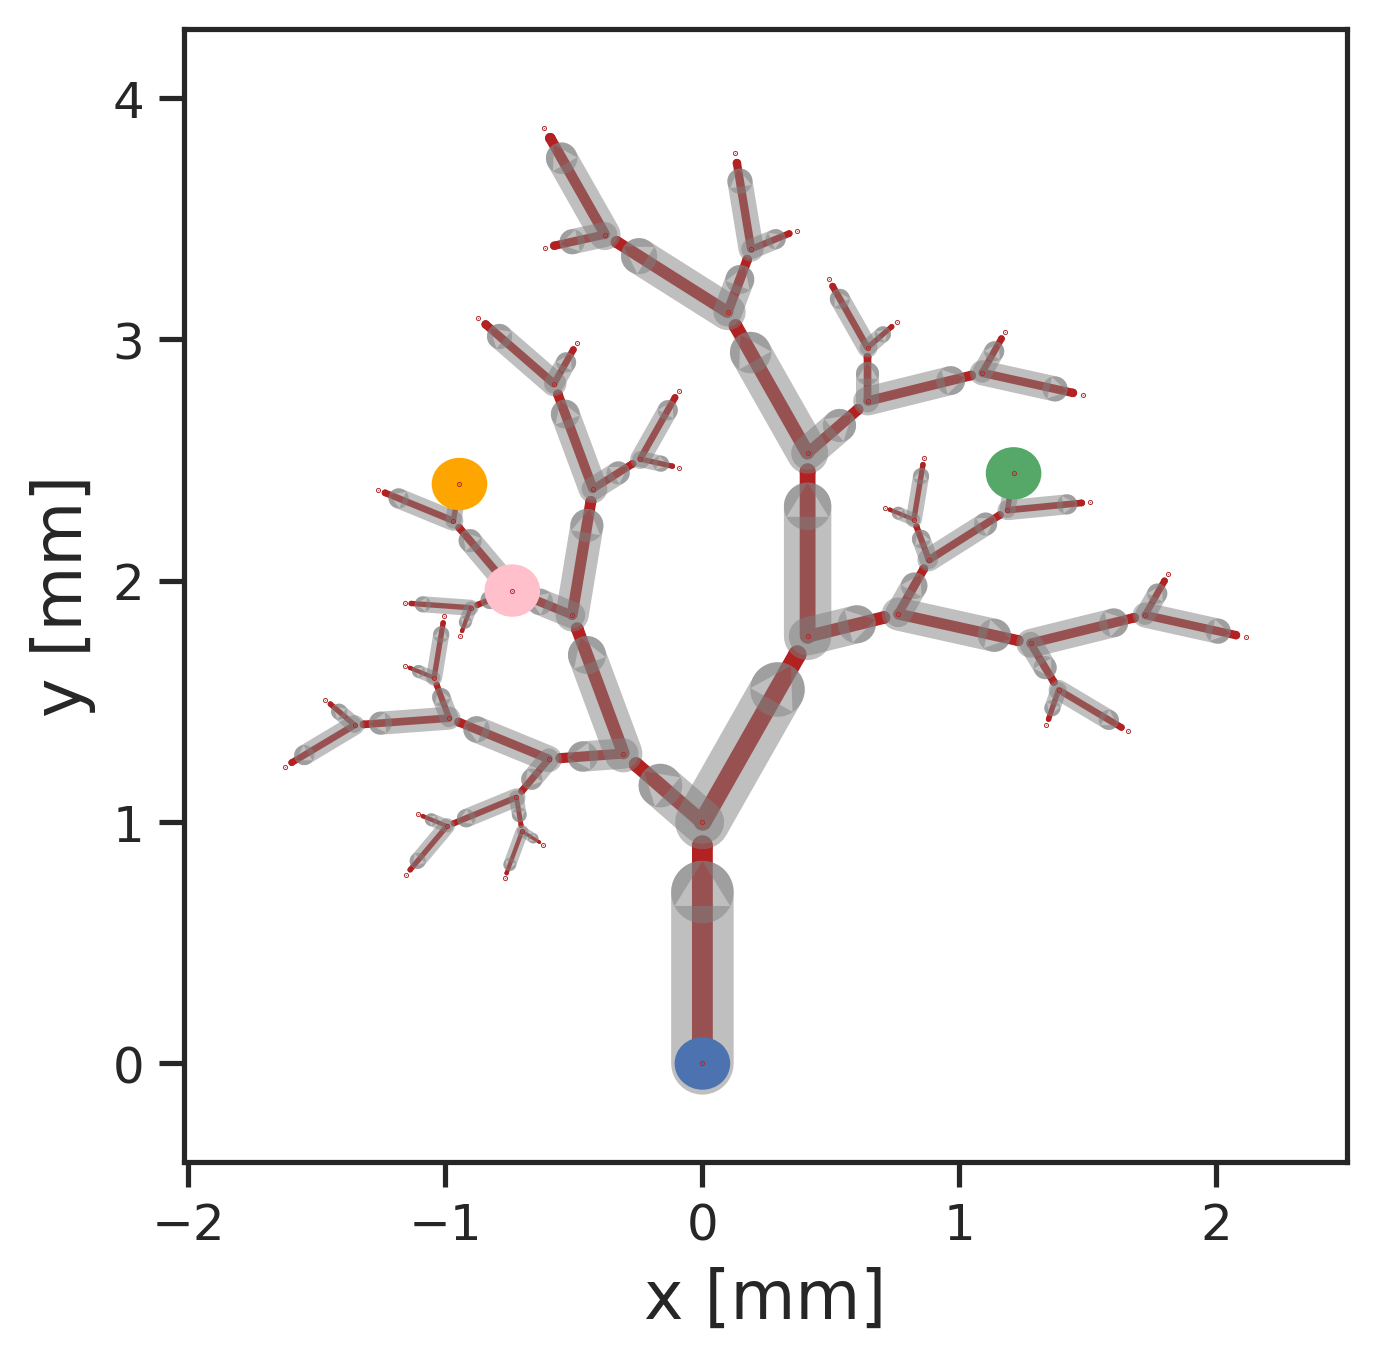

In [67]:
# Make mesh
sns.set_style('white')

def plot_tree(G, fname=None):
    pos = nx.get_node_attributes(G, 'pos')
    pos2d = [coord[0:2] for coord in list(pos.values())]

    radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    nx.draw_networkx(G, pos2d, width=radius*50, edge_color='firebrick', 
                    with_labels=False, node_size=0.05, node_color='firebrick', arrowsize=0.1, ax=ax)
    
    nx.draw_networkx(G, pos2d, width=radius*150, edge_color='gray', 
                    with_labels=False, node_size=0.001, node_color='gray', arrowsize=0.1, ax=ax, alpha=0.5)

    
    ax.set_xlabel('x [mm]', fontsize=16)
    ax.set_ylabel('y [mm]', fontsize=16)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=12)

    return fig, ax

fig, ax = plot_tree(G)

pos = nx.get_node_attributes(G, 'pos')
pos2d = [coord[0:2] for coord in list(pos.values())]

root_v = 0 #inlet is the first vertex in the network

# find other boundary points 
adj_matrix = nx.adj_matrix(G).todense()
bps = np.where(np.sum(adj_matrix, axis=1)==0)[0]

leaf1_v, leaf2_v = bps[10], bps[15]

inner_v = 10

root_pos = G.nodes()[root_v]['pos']
leaf_poss= [G.nodes()[bps[v]]['pos'] for v in [10,18]]
inner_pos = G.nodes()[inner_v]['pos']

poss = [root_pos] + leaf_poss + [inner_pos]

radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

colors = ['b', 'orange', 'g', 'pink']

for ix, pos in enumerate(poss):
    circle1 = plt.Circle((pos[0], pos[1]), 0.1, color=colors[ix])
    ax.add_patch(circle1)
    
plt.savefig('tree.png')

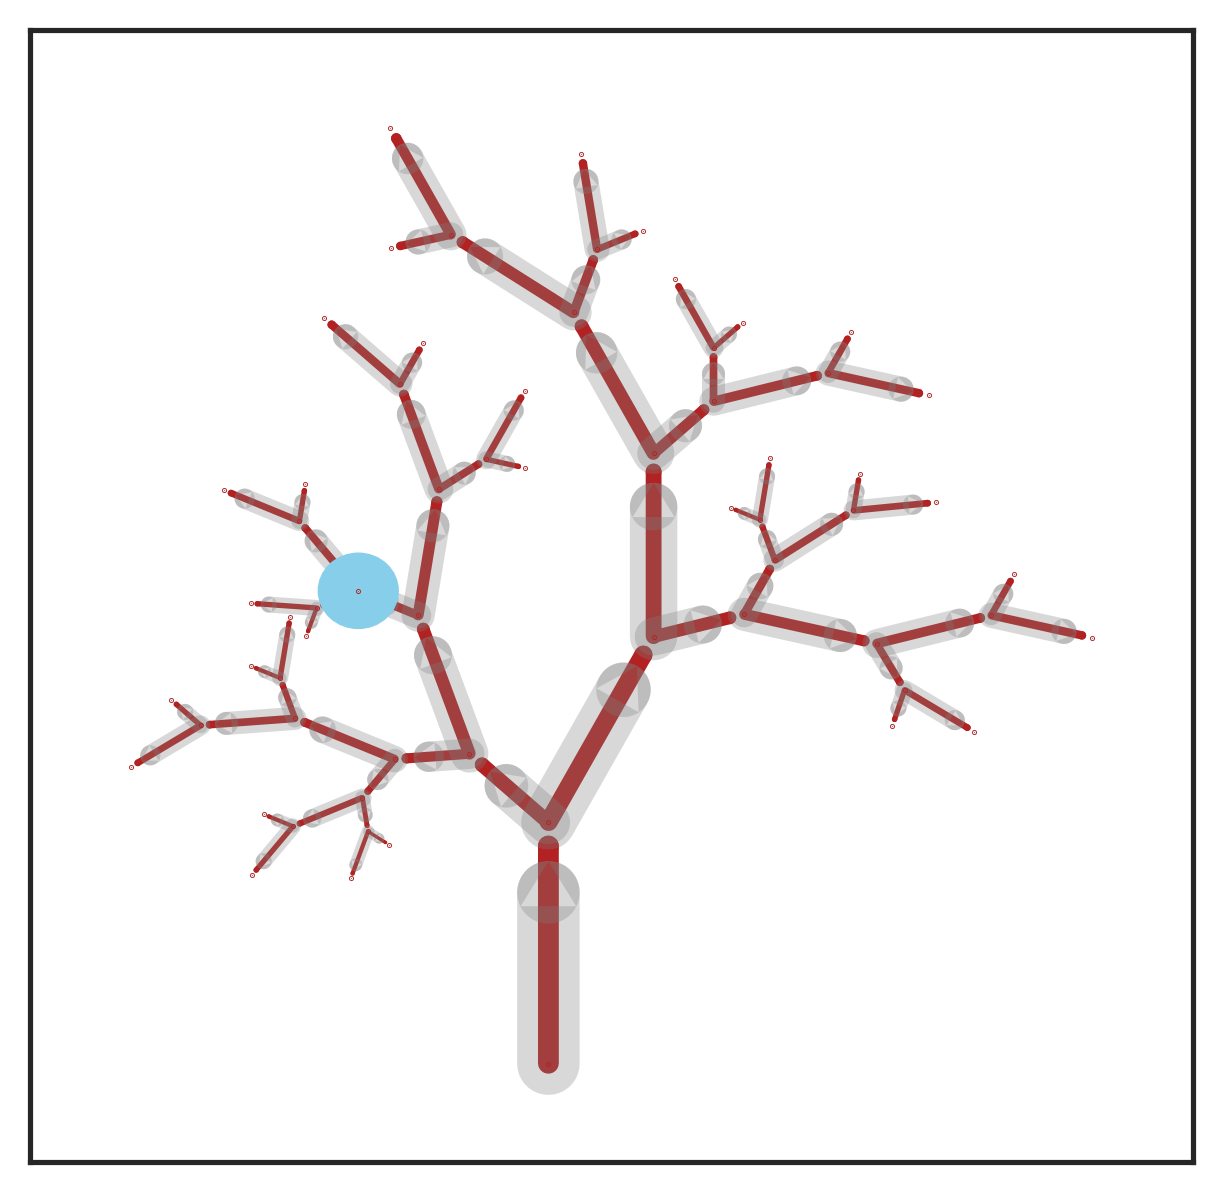

In [68]:
# Make mesh
sns.set_style('white')

def plot_tree(G, fname=None):
    pos = nx.get_node_attributes(G, 'pos')
    pos2d = [coord[0:2] for coord in list(pos.values())]

    radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    nx.draw_networkx(G, pos2d, width=radius*50, edge_color='firebrick', 
                    with_labels=False, node_size=0.05, node_color='firebrick', arrowsize=0.1, ax=ax)
    
    nx.draw_networkx(G, pos2d, width=radius*150, edge_color='gray', 
                    with_labels=False, node_size=0.001, node_color='gray', arrowsize=0.1, ax=ax, alpha=0.3)

    return fig, ax

fig, ax = plot_tree(G)

pos = nx.get_node_attributes(G, 'pos')
pos2d = [coord[0:2] for coord in list(pos.values())]

inner_v = 10

inner_pos = G.nodes()[inner_v]['pos']

poss = [inner_pos]

radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

colors = ['skyblue']

for ix, pos in enumerate(poss):
    circle1 = plt.Circle((pos[0], pos[1]), 0.15, color=colors[ix])
    ax.add_patch(circle1)
    
plt.savefig('tree_small.png')

In [69]:
T = n_cycles/min(freqs) # total simulation time
time_steps = len(qps)
dt = T/time_steps
ts = np.linspace(0, T, time_steps)

time_steps_per_cycle = int(len(qps)/n_cycles)



e = (0,1)
radius1 = G.edges()[e]['radius1']
radius2 = G.edges()[e]['radius2']
area = np.pi*(radius2**2-radius1**2)
area

0.25132741228718347

In [70]:
ffile_p = TubeFile(G, folder_name + '/plots/p.pvd')
ffile_q = File(folder_name + '/plots/q.pvd')
ffile_v = File(folder_name + '/plots/v.pvd')

for e in G.edges():
    radius1 = G.edges()[e]['radius1']
    radius2 = G.edges()[e]['radius2']
    G.edges()[e]['area'] = np.pi*(radius2**2-radius1**2)
    
area_dict = nx.get_edge_attributes(G, 'area')
mesh0, foo = G.get_mesh(0)
DG = FunctionSpace(mesh0, 'DG', 0)
area = Function(DG)
area.vector()[:] = list(area_dict.values())
area.set_allow_extrapolation(True)

tangent = TangentFunction(G, degree=1)

steps = 1
for i in tqdm(range(1000, 4000, steps)):
    
    t = i*dt
    
    ps[i].rename('p', '0')
    ffile_p << (ps[i], float(t))
    
    q = project(tangent*qs[i], VectorFunctionSpace(G.mesh, 'DG', 1))
    q.rename('q', '0')
    ffile_q << (q, float(t))
    
    v = project(tangent*qs[i]/area, VectorFunctionSpace(G.mesh, 'DG', 1))
    v.rename('v', '0')
    ffile_v << (v, float(t))

100%|██████████| 3000/3000 [05:32<00:00,  9.02it/s]


NameError: name 'outflows_root' is not defined

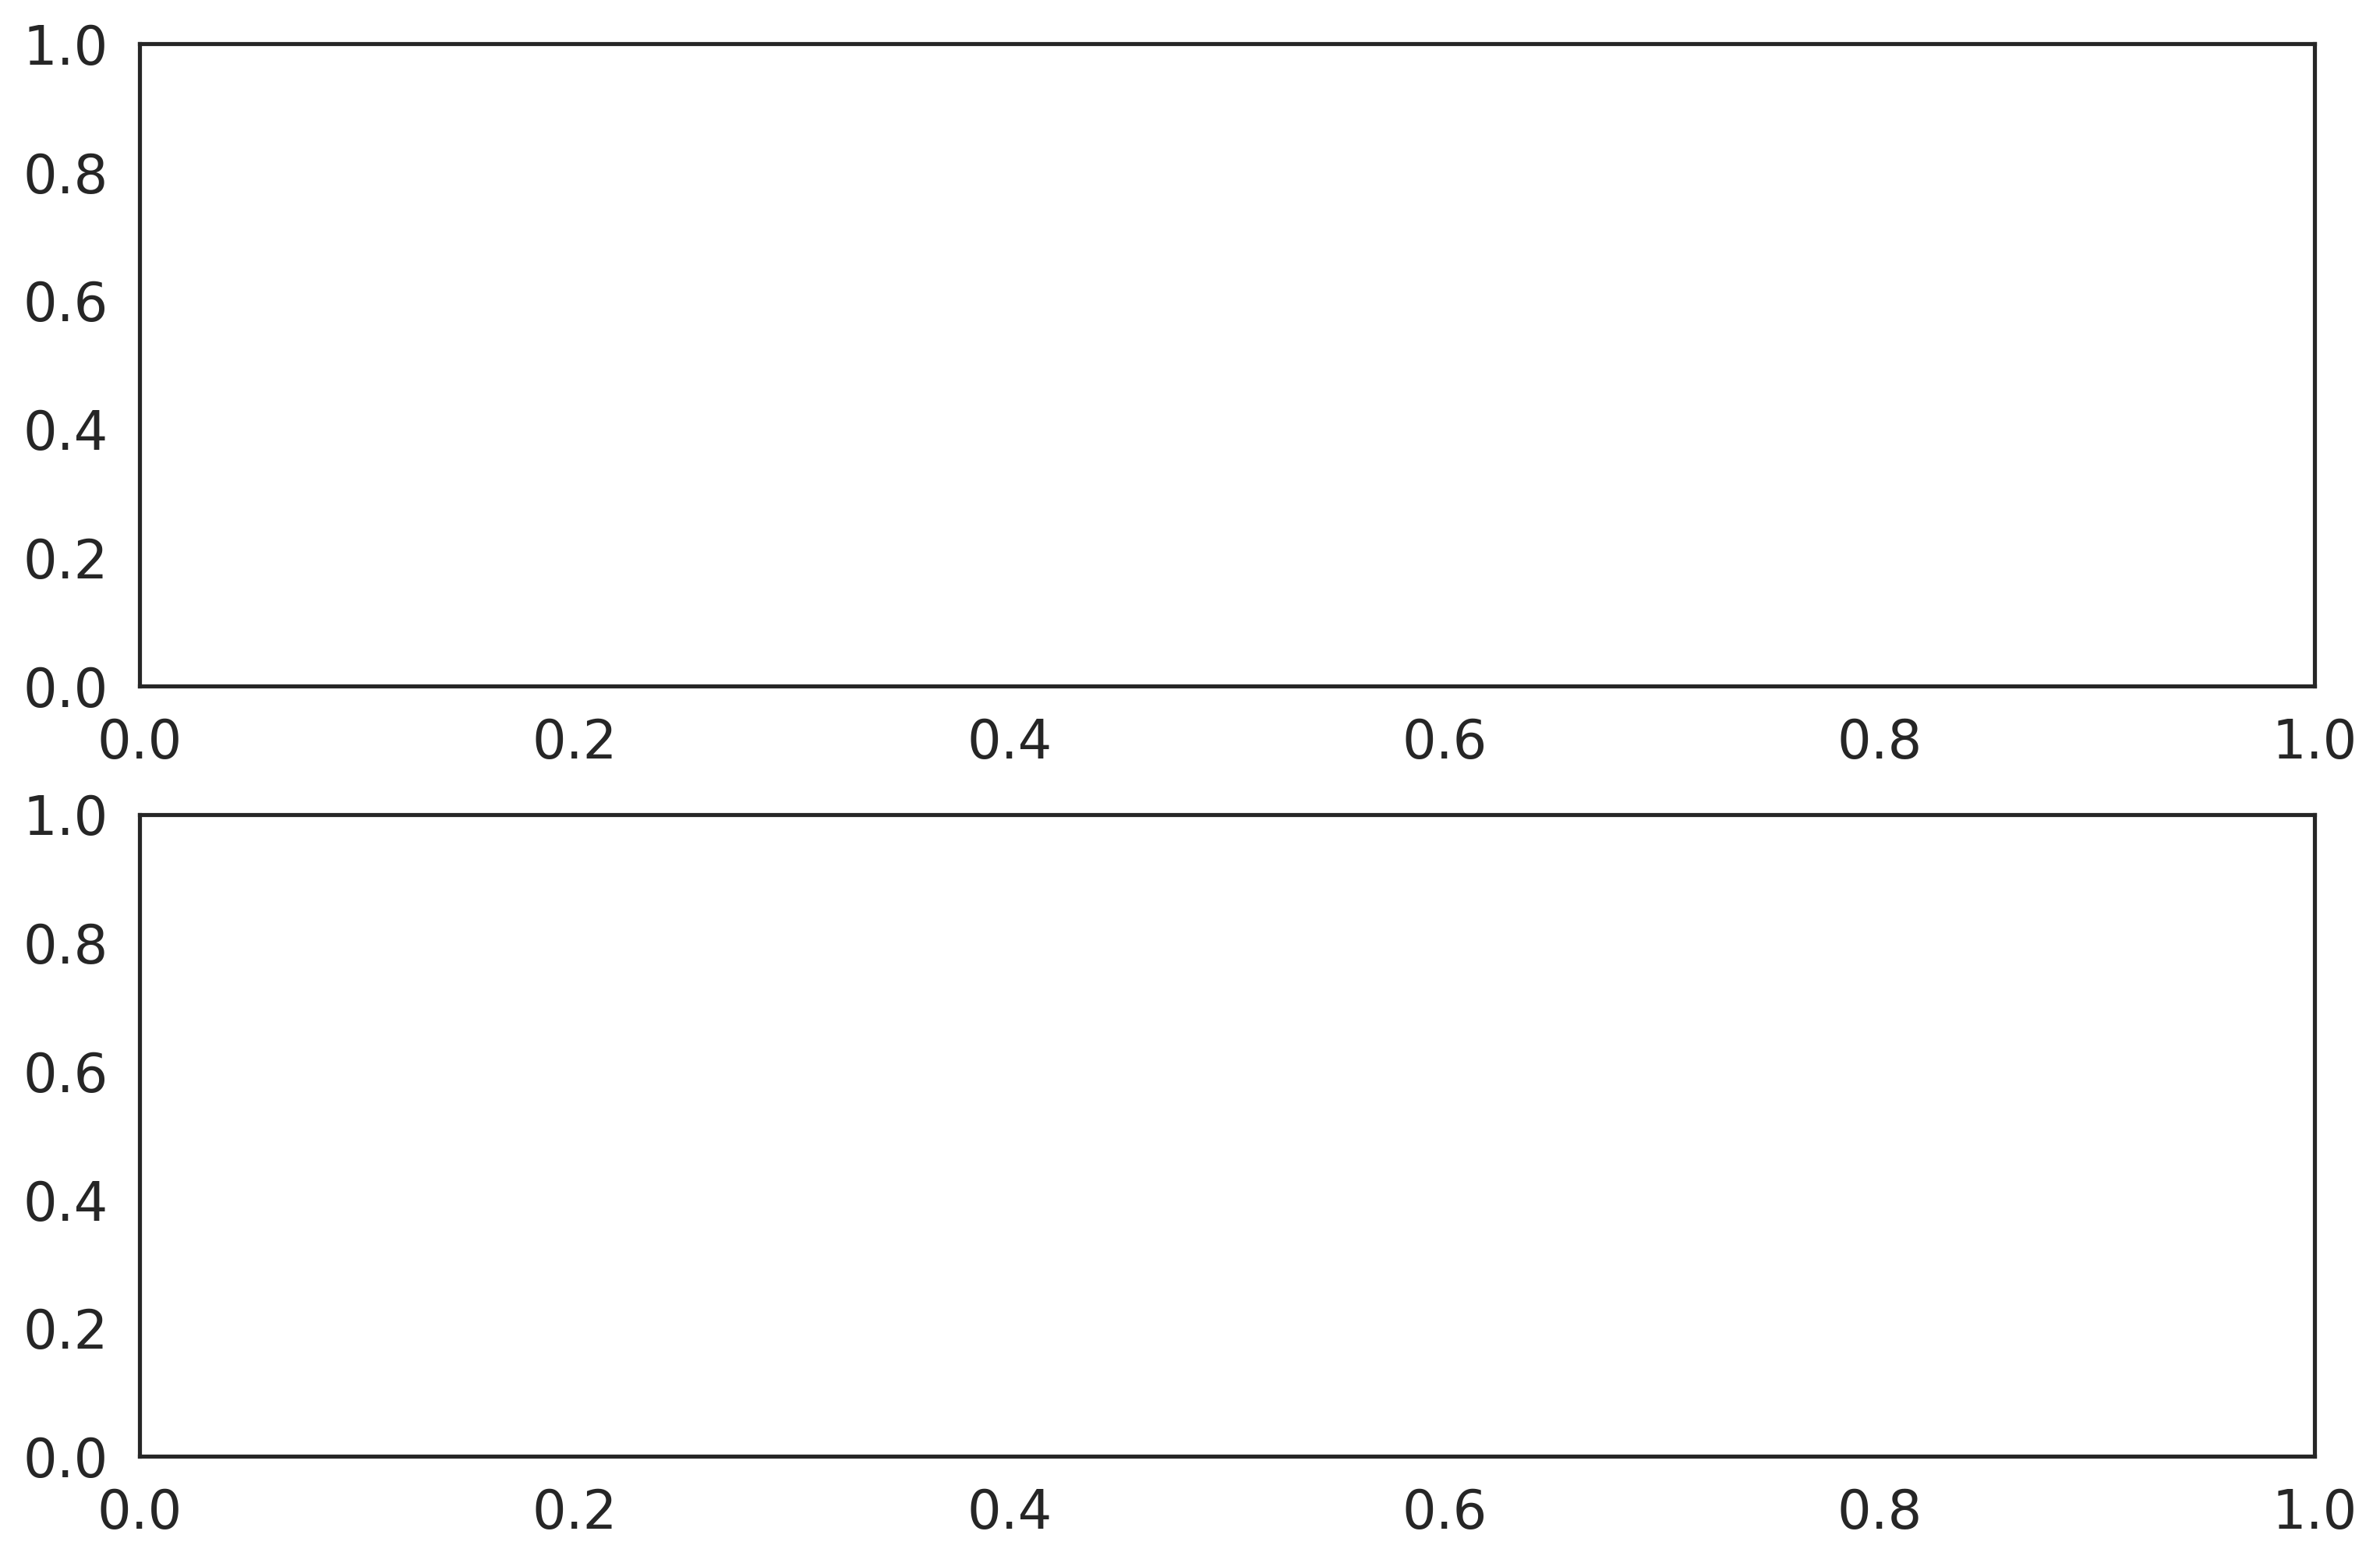

In [71]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(12,8))
axs[0].plot(ts[(n_cycles-1)*time_steps_per_cycle:], outflows_root[(n_cycles-1)*time_steps_per_cycle:], linewidth=2, color=colors[0])
axs[1].plot(ts[(n_cycles-1)*time_steps_per_cycle:], outflows_leaf2[(n_cycles-1)*time_steps_per_cycle:], linewidth=2, color=colors[2])

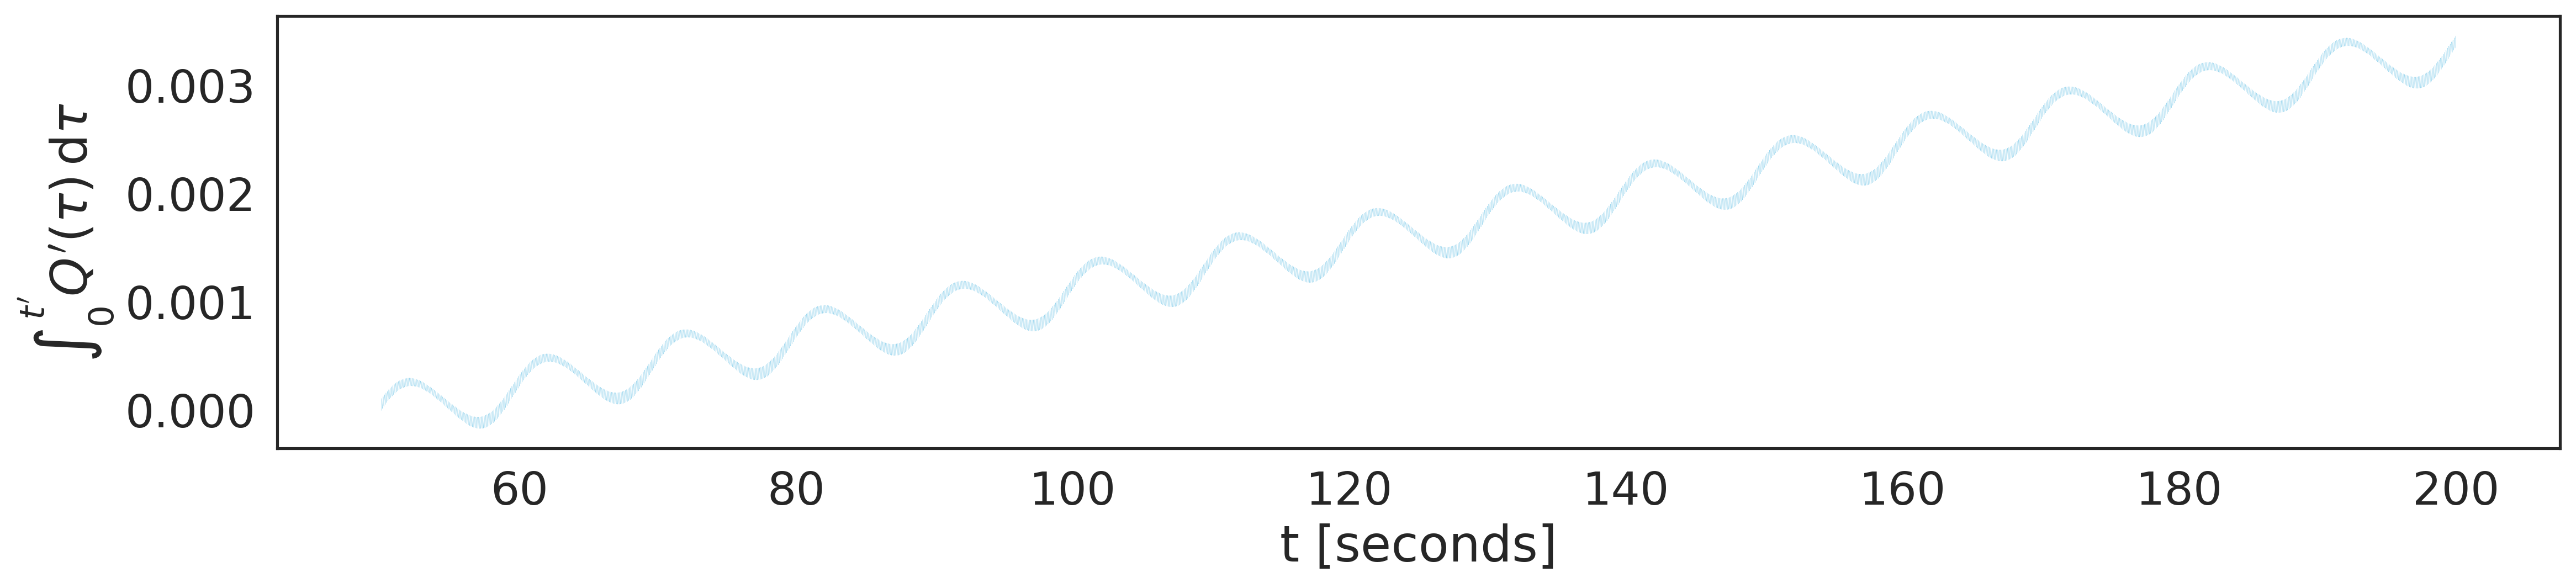

In [72]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.8, style='white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


T = n_cycles/min(freqs) # total simulation time
time_steps = len(qps)
dt = T/time_steps
outflowss = [[q(pos) for q in qs] for pos in poss]

ts = np.linspace(0, T, time_steps)[5*tsteps_per_cycle:]

plt.figure(figsize=(16,4))

ix = 0 # need to be zero since only first experiment is ran in run_interaction_simulation
outflows = outflowss[ix]
ys = np.cumsum(outflows[5*tsteps_per_cycle:])*dt    
plt.plot(ts, ys, linewidth=0.1, color=colors[ix])
plt.xlabel('t [seconds]')
plt.ylabel('$\int_{0}^{t\'} Q\'(\\tau)\,\mathrm{d}\\tau$')
plt.tight_layout()
plt.savefig(f'netflow_{ix}.png')

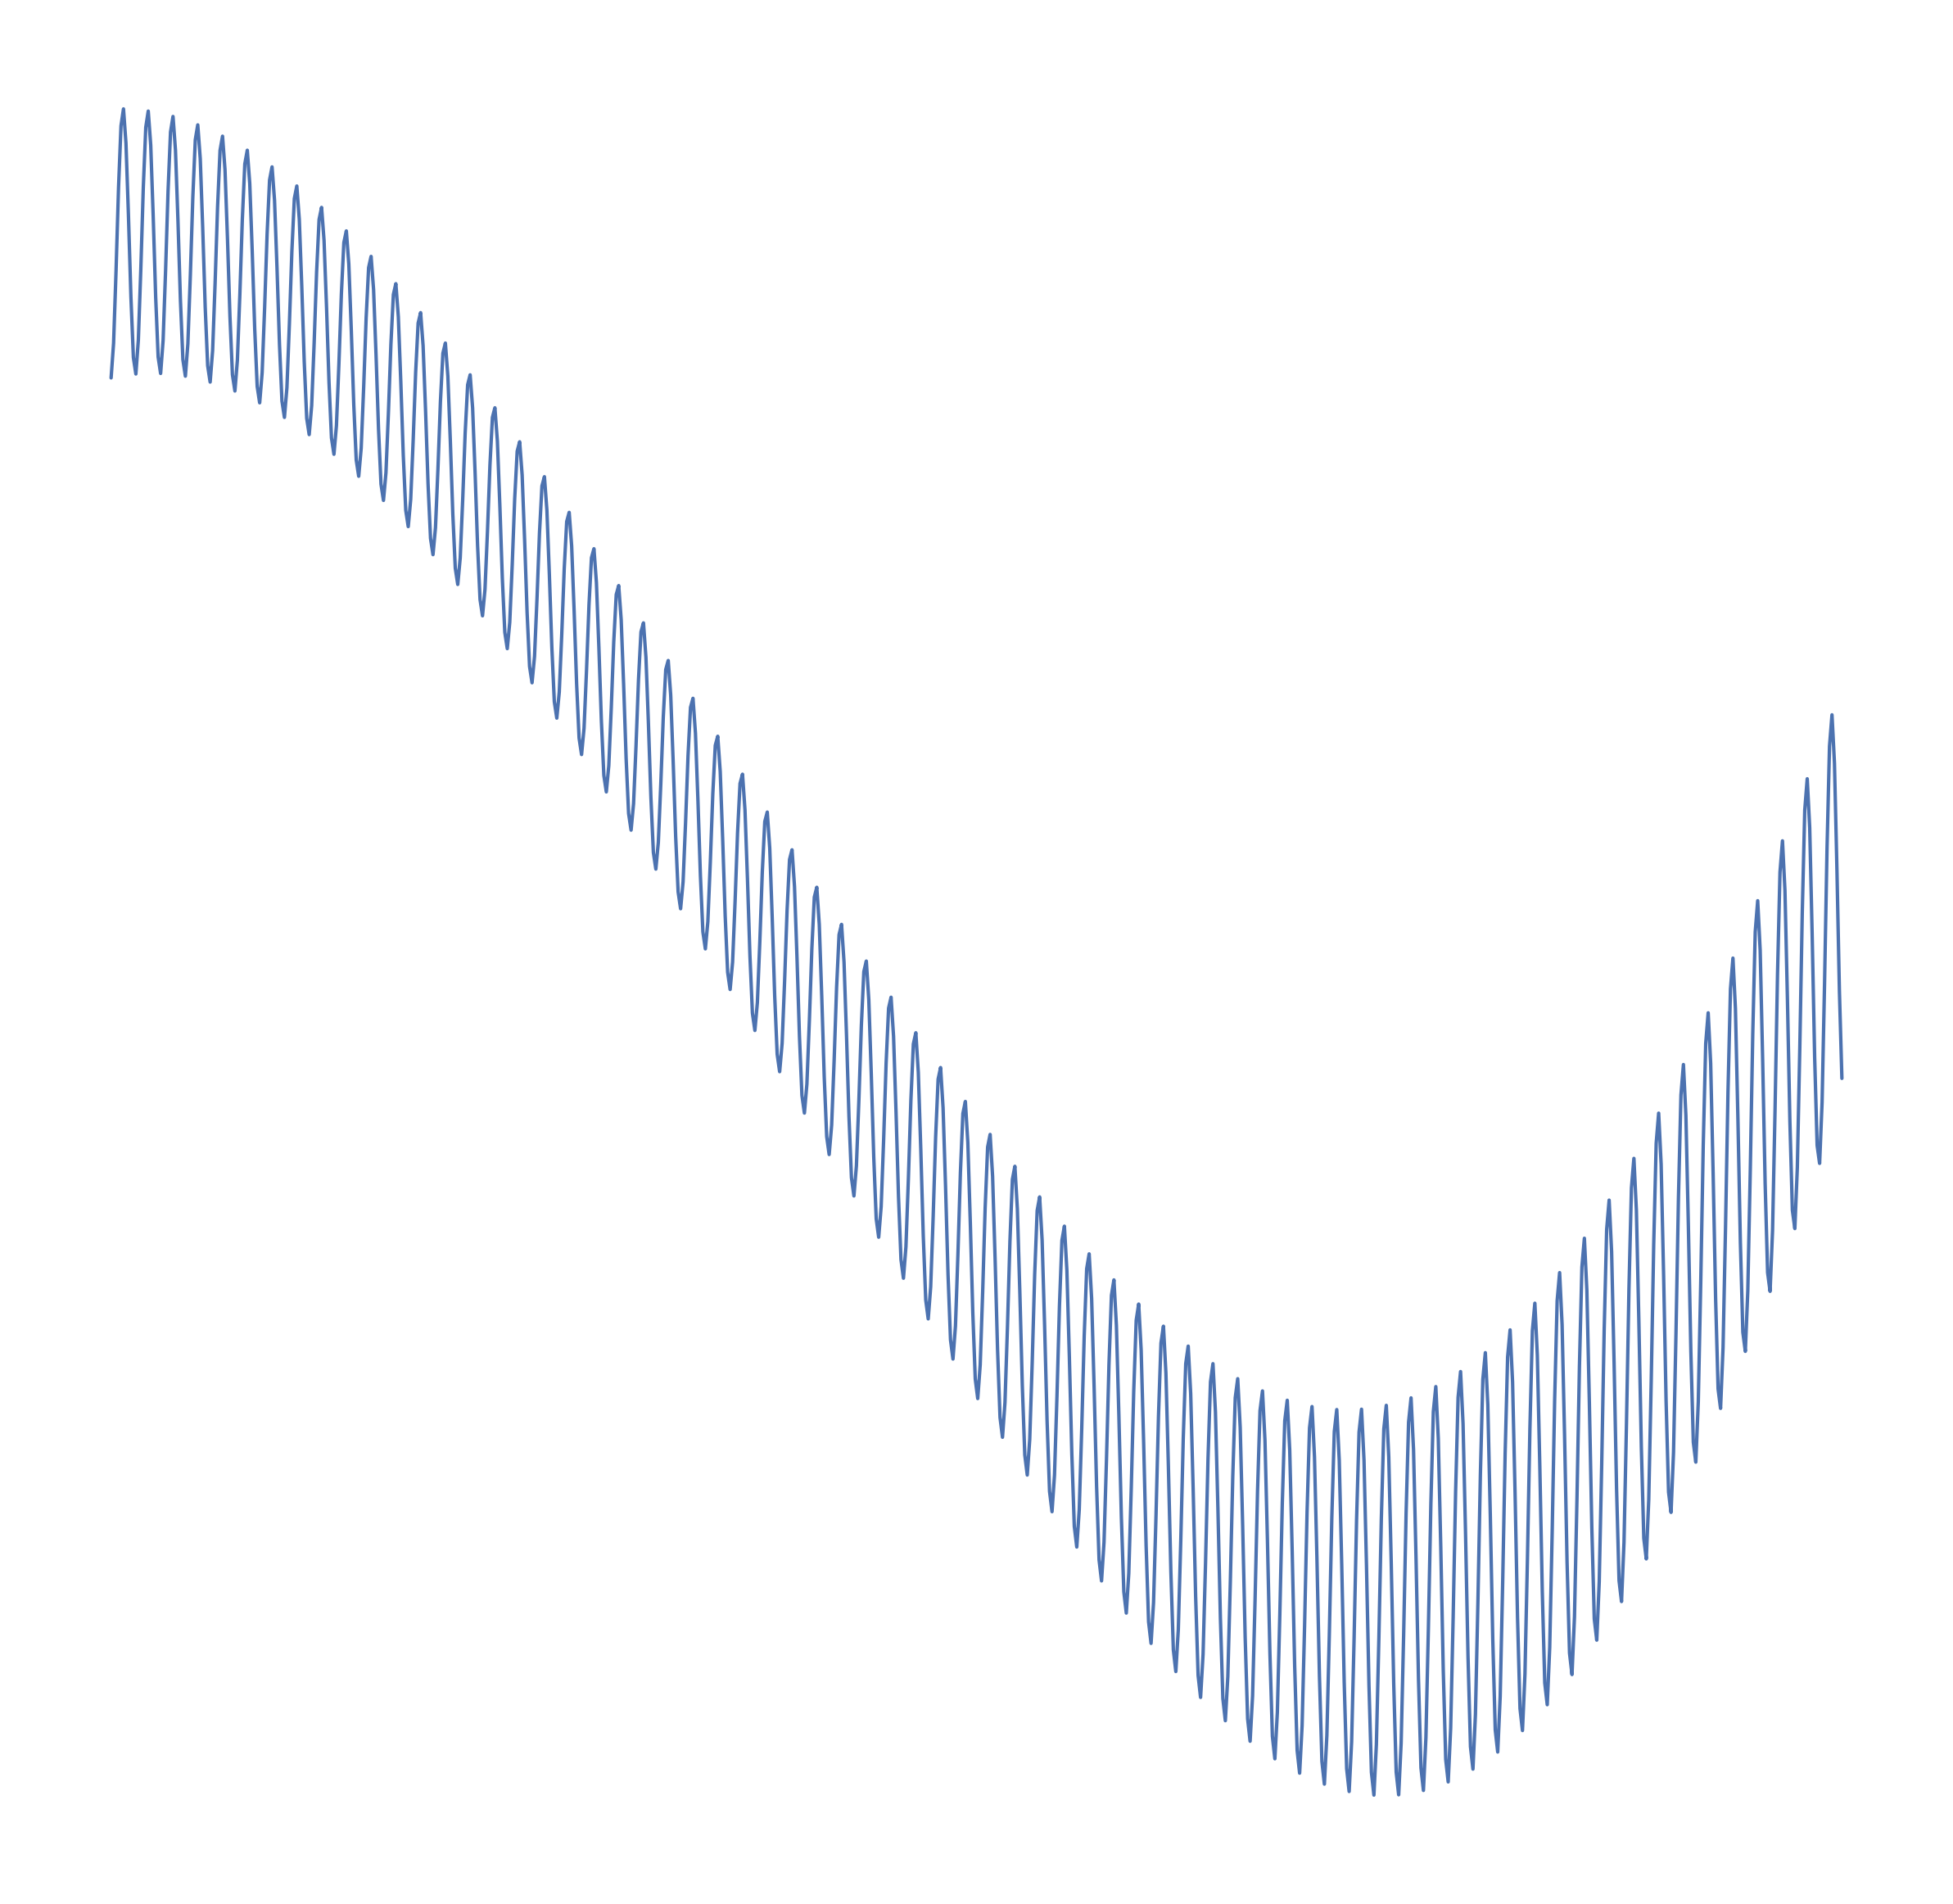

In [73]:
plt.figure(figsize=(10,10))
time_steps_per_cycles=1000
plt.plot(ts[1200:1900], ys[1200:1900], linewidth=1, color='b')
plt.axis('off')
plt.savefig('netflow_closeup')

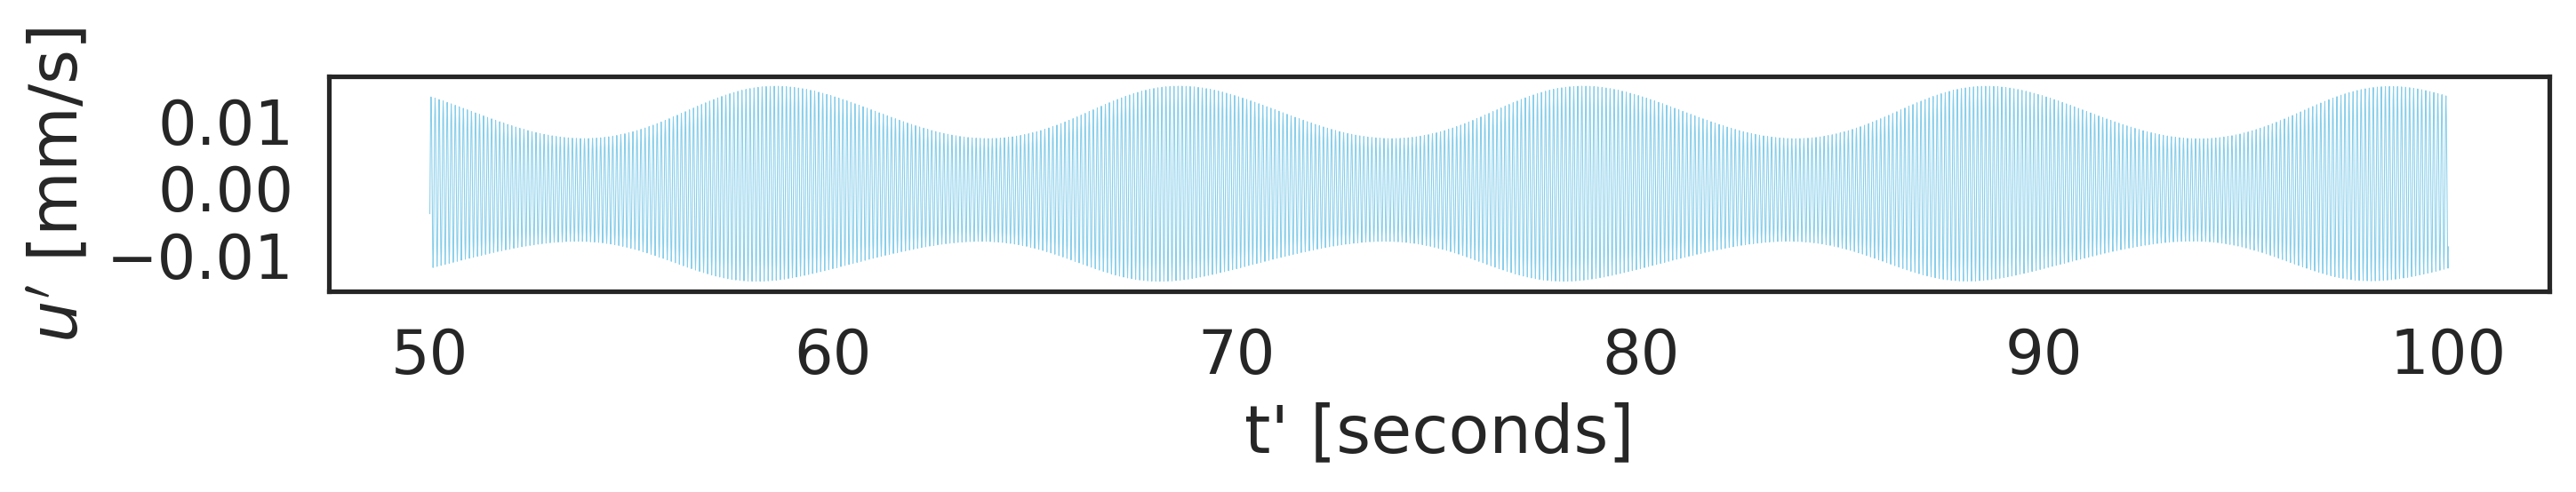

In [74]:
area_dict = nx.get_edge_attributes(G, 'area')
mesh0, foo = G.get_mesh(0)
DG = FunctionSpace(mesh0, 'DG', 0)
area = Function(DG)
area.vector()[:] = list(area_dict.values())
area.set_allow_extrapolation(True)


# Compute net flow from simulation
node = list(G.nodes())[inner_v]
pos = G.nodes()[node]['pos']
outflows = [sol[0](pos) for sol in qps]

sns.set(font_scale=1.5, style='white')

plt.figure(figsize=(10,2))
plt.plot(ts[:5000], outflows[1000:6000]/area(0,0,0), linewidth=0.25, color='skyblue')
plt.xlabel('t\' [seconds]')
plt.ylabel('$u\'$ [mm/s]')
plt.tight_layout()
plt.savefig('outflow_interior_node.png')

In [75]:
radius

array([0.1       , 0.06970106, 0.08712633, 0.04858238, 0.06072797,
       0.06072797, 0.07590997, 0.03386243, 0.04232804, 0.04232804,
       0.05291005, 0.04232804, 0.05291005, 0.05291005, 0.06613757,
       0.02360248, 0.02950309, 0.02950309, 0.03687887, 0.02950309,
       0.03687887, 0.03687887, 0.04609859, 0.02950309, 0.03687887,
       0.03687887, 0.04609859, 0.03687887, 0.04609859, 0.04609859,
       0.05762323, 0.01645118, 0.02056397, 0.02056397, 0.02570496,
       0.02056397, 0.02570496, 0.02570496, 0.0321312 , 0.02056397,
       0.02570496, 0.02570496, 0.0321312 , 0.02570496, 0.0321312 ,
       0.0321312 , 0.040164  , 0.02056397, 0.02570496, 0.02570496,
       0.0321312 , 0.02570496, 0.0321312 , 0.0321312 , 0.040164  ,
       0.02570496, 0.0321312 , 0.0321312 , 0.040164  , 0.0321312 ,
       0.040164  , 0.040164  , 0.05020501])

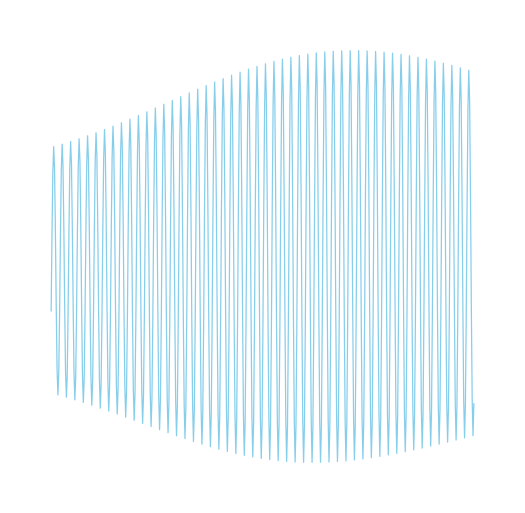

In [76]:


# Compute net flow from simulation
node = list(G.nodes())[inner_v]
pos = G.nodes()[node]['pos']
outflows = [sol[0](pos) for sol in qps]

sns.set(font_scale=1.5, style='white')

plt.figure(figsize=(2,2))
plt.plot(ts[500:1000], outflows[1500:2000], linewidth=0.3, color='skyblue')
plt.axis('off')
plt.savefig('outflow_interior_node_closeup.png')